## Import

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import time 
import numpy as np
import pandas as pd
import math 
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

## Visualization

In [2]:
def draw_solution(Solution, original_graph):

    G = nx.Graph()

    for vert in original_graph.keys():
        G.add_node(vert)
        for neighbour in original_graph[vert]:
            G.add_node(neighbour[0])
            G.add_edge(vert, neighbour[0], weight = neighbour[1])

    # Create a dictionary specifying the color of each edge
    edge_colors = ['red' if (e in Solution or e[::-1] in Solution) else 'black' for e in G.edges()]
    edge_weights = {(u, v): data['weight'] for u, v, data in G.edges(data=True)}


    # Display a graph with specified edge colors
    plt.figure(figsize=(5, 5))
    pos = nx.spring_layout(G) 
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_weight='bold', font_size=12, edge_color=edge_colors)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_color='black')

    plt.title('MST')
    plt.show()

## Graph generation

In [3]:
## The function generates an undirected unweighted graph as an adjacency list
def get_random_simple_Gnp_graph(n, seed=42):
  edge_p = 1/2   ## probability of an edge between vertices 0.5
  g = nx.random_graphs.fast_gnp_random_graph(n,edge_p,seed)
  return nx.convert.to_dict_of_lists(g)

## Generation of a weighted undirected graph with edge weights from 1 to 10
def get_graph(number_of_vertex):
  graph_without_weights = get_random_simple_Gnp_graph(number_of_vertex)
  weighted_graph = {}

  for node in graph_without_weights:
      weighted_graph[node] = {}
      for neighbor in graph_without_weights[node]:
          # Assigning a random weight to an edge
          weighted_graph[node][neighbor] = random.randint(1, 10)
          # Adding a back edge to an undirected graph
          if neighbor not in weighted_graph:
              weighted_graph[neighbor] = {}
          weighted_graph[neighbor][node] = weighted_graph[node][neighbor]
          
  for vert in weighted_graph:
     weighted_graph[vert]=list(weighted_graph[vert].items())
    
  return weighted_graph

In [4]:
def get_number_edges(graph):
    total_edges = 0
    for vert in graph:
        total_edges += len(graph[vert])
    return int(total_edges/2)

## Test solution

In [5]:
def adjacency_list_to_matrix(graph):
    nodes = list(graph.keys()) 
    n = len(nodes) 
    adjacency_matrix = [[0 for _ in range(n)] for _ in range(n)]
    
    # Fill the matrix with edge weight values
    for i in range(n):
        node = nodes[i]
        for neighbor, weight in graph[node]:
            j = nodes.index(neighbor)
            adjacency_matrix[i][j] = weight
    
    return adjacency_matrix


In [6]:
def test_solution(sol_own, sol_comp):
    sum_MST_comp = sum(sum(row) for row in sol_comp.toarray().astype(int))
    sum_MST_own = sum(third for _, _, third in sol_own)
    return sum_MST_comp == sum_MST_own

## Prim's algorithm with labels

In [7]:
def Prima_with_labels(graph):

    # Stage 1: Initialization
    start_vert = 0 
    label = [0]*len(graph)
    length_projections = [float('inf')]*len(graph)
    second_ends = [len(graph)]*len(graph)
    Solution = []

    label[start_vert] = 1
    for neighbour in graph[start_vert]:
        length_projections[neighbour[0]] = neighbour[1]
        second_ends[neighbour[0]] = start_vert
    
    # Stage 2: Tree construction
    while(len(Solution) < len(graph) - 1):

        ## search for next vertex
        min_value = float('inf')
        next_vert = None
        for vert, weight in enumerate(length_projections):
            if label[vert] == 0 and weight < min_value:
                next_vert = vert
                min_value = weight

        ## mark it
        label[next_vert] = 1

        ## throw an edge into the solution
        Solution.append((second_ends[next_vert], next_vert, min_value))

        for neighbour in graph[next_vert]:
            if label[neighbour[0]] == 0:
                if length_projections[neighbour[0]] > neighbour[1]:
                    length_projections[neighbour[0]] = neighbour[1]
                    second_ends[neighbour[0]] = next_vert
    return Solution

        

In [8]:
times_labels = []
TEST = {'PASS': 0, 'NOT PASS': 0}

for num_vert in np.arange(3, 1000):
    graph = get_graph(num_vert)
    graph = dict(sorted(graph.items()))
    
    X = adjacency_list_to_matrix(graph)
    sol_comp = minimum_spanning_tree(X)
    
    start = time.time() 
    sol_own = Prima_with_labels(graph)
    times_labels.append(time.time() - start)

    if test_solution(sol_own, sol_comp):
        TEST['PASS'] += 1
    else:
        TEST['NOT PASS'] += 1
        
print(pd.DataFrame.from_dict(TEST, orient = 'index', columns = ['TEST']))

          TEST
PASS       997
NOT PASS     0


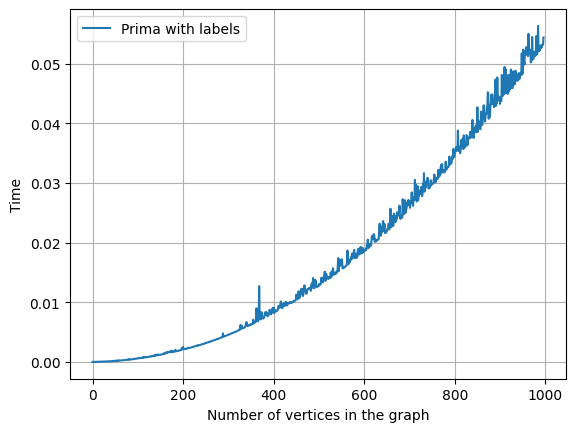

In [9]:
plt.plot(times_labels, label = 'Prima with labels')
plt.legend()
plt.xlabel('Number of vertices in the graph')
plt.ylabel('Time')
plt.grid()
plt.show()

## Prim's algorithm with 2heap

In [10]:
class dHeap:
    def __init__(self, array_weight, array_vertex, d):
        self.array_weight = array_weight
        if array_vertex == None:
            self.array_vertex = list(range(len(self.array_weight)))
        else:
            self.array_vertex = array_vertex
        self.d = d
    
    def swap(self, vert_1, vert_2):
        self.array_vertex[vert_1], self.array_vertex[vert_2] =  self.array_vertex[vert_2], self.array_vertex[vert_1]
        self.array_weight[vert_1], self.array_weight[vert_2] =  self.array_weight[vert_2], self.array_weight[vert_1]

    def find_left_child(self, parent, n):
        left_child = parent * self.d + 1  # formula: i * d + 1  => d = 2
        if (left_child <= n-1):
            return left_child
        else:
            return -1

    def find_right_child(self, parent, n):
        left_child = self.find_left_child(parent, n)
        if (left_child == -1):
            return -1
        else:
            return min(left_child + self.d - 1, n  - 1)

    def find_min_child(self, parent):
        left_child = self.find_left_child(parent, len(self.array_weight))
        right_child = self.find_right_child(parent, len(self.array_weight))
        if left_child == -1 or right_child == -1:
            return -1
        else:
            weight_min_child = self.array_weight[left_child]
            min_child = left_child
            for vert in range(left_child, right_child + 1):
                if self.array_weight[vert] < weight_min_child :
                    weight_min_child = self.array_weight[vert]
                    min_child = vert
            return min_child

    def find_parent(self, child):
        if child == 0:
            return -1
        else:
            return (child - 1) // self.d  

    def diving(self, vertex):

        j1 = vertex
        j2 = self.find_min_child(vertex)
        while ((j2 != -1) and (self.array_weight[j1] > self.array_weight[j2])):
            self.swap(j1, j2)
            j1 = j2 
            j2 = self.find_min_child(j1)

    def heaping(self):
        for vert in range(len(self.array_weight) - 1, -1, -1):
            self.diving(vert)
    
    def emersion(self, vertex):

        weight_vertex = self.array_weight[vertex]
        name_vertex = self.array_vertex[vertex]

        parent = self.find_parent(vertex)

        while (vertex != 0) and (self.array_weight[parent] > weight_vertex):
            self.array_weight[vertex] = self.array_weight[parent]
            self.array_vertex[vertex] = self.array_vertex[parent]

            vertex = parent
            parent = self.find_parent(vertex)

        self.array_weight[vertex] = weight_vertex  
        self.array_vertex[vertex] = name_vertex


    def decrease_weight(self, vertex, delta):
        self.array_weight[vertex] = delta
        self.emersion(vertex)

    def insert(self, new_weight):
        self.array_weight.append(new_weight)
        self.array_vertex.append(len(self.array_weight) - 1)
        self.emersion(len(self.array_weight) - 1)

    def delete_minimum_vertex(self):
        self.swap(0, len(self.array_weight) - 1)

        self.array_weight = self.array_weight[:-1]
        self.array_vertex = self.array_vertex[:-1]

        self.diving(0)

    def delete_vertex(self, vertex):
        self.decrease_weight(vertex, -float('inf'))
        self.delete_minimum_vertex()
    

In [11]:
def Prima_2heap(graph):

    start_vert = 0 
    label = [0]*len(graph)
    length_projections = dHeap(array_weight = [float('inf')]*len(graph), array_vertex = None, d = 2)
    second_ends = [len(graph)]*len(graph)
    Solution = []

    label[start_vert] = 1
    length_projections.delete_minimum_vertex()

    for neighbour in graph[start_vert]:
        index = length_projections.array_vertex.index(neighbour[0])
        length_projections.decrease_weight(index, neighbour[1])
        second_ends[neighbour[0]] = start_vert
        
    while(len(Solution) < len(graph) - 1):

        ## search for next vertex
        next_vert = length_projections.array_vertex[0]
        min_value = length_projections.array_weight[0]

        ## throw edges into the solution
        Solution.append((second_ends[next_vert], next_vert, min_value))
        
        ## mark it
        label[next_vert] = 1
        length_projections.delete_minimum_vertex()

        for neighbour in graph[next_vert]:

            if label[neighbour[0]] == 0:
                 index = length_projections.array_vertex.index(neighbour[0])
                 if length_projections.array_weight[index] > neighbour[1]:
                        length_projections.decrease_weight(index, neighbour[1])
                        second_ends[neighbour[0]] = next_vert  

    return Solution
    


In [13]:
times_2heap = []
TEST = {'PASS': 0, 'NOT PASS': 0}
complexity = []
for num_vert in np.arange(3, 1000):
    graph = get_graph(num_vert)

    X = adjacency_list_to_matrix(graph)
    sol_comp = minimum_spanning_tree(X)
    
    start = time.time() 
    sol_own = Prima_2heap(graph)
    times_2heap.append(time.time() - start)
    complexity.append(get_number_edges(graph)*math.log(num_vert, 2))

    if test_solution(sol_own, sol_comp):
        TEST['PASS'] += 1
    else:
        TEST['NOT PASS'] += 1
        
print(pd.DataFrame.from_dict(TEST, orient = 'index', columns = ['TEST']))

          TEST
PASS       997
NOT PASS     0


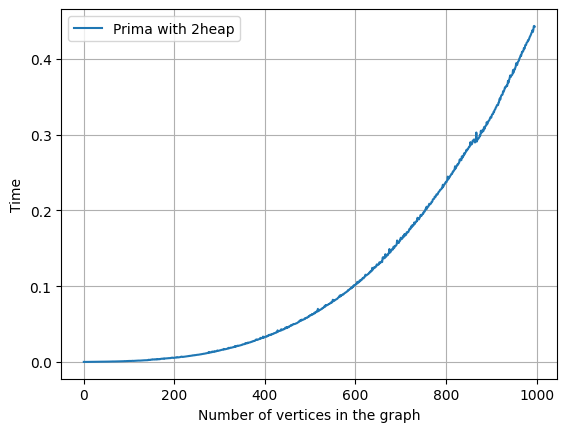

In [14]:
plt.plot(times_2heap, label = 'Prima with 2heap')
plt.legend()
plt.xlabel('Number of vertices in the graph')
plt.ylabel('Time')
plt.grid()
plt.show()

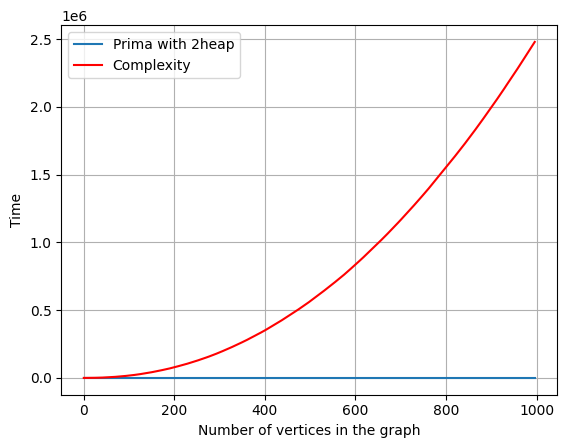

In [15]:
plt.plot(times_2heap, label = 'Prima with 2heap')
plt.plot(complexity, color = 'red', label = 'Complexity')
plt.legend()
plt.xlabel('Number of vertices in the graph')
plt.ylabel('Time')
plt.grid()
plt.show()

## Prim's algorithm with fibonacci heap

In [16]:
import math

class Node():
    def __init__(self, key, val):
        self.key = key
        self.val = val
        self.parent = self.child = None
        self.left = self.right = self
        self.degree = 0
        self.flag = False

class FibonacciHeap():
    def __init__(self):
        self.min = None
        self.no_nodes = 0

    # O(1)
    def find_min(self):
        return self.min

    # O(1)
    def insert(self, key, value=None):
        if value is None:
            value = key
        n = Node(key, value)

        if self.no_nodes == 0:
            self.min = n
        else:
            self.add_root(n)

        self.no_nodes += 1

        return n

    # O(log n)
    def delete(self, node):
        self.decrease_key(node, self.min.key - 1)
        self.delete_min()


    # O(log n)
    def delete_min(self):
        prev_min = self.min
        if prev_min is not None:

            # move children to root
            if prev_min.child is not None:
                n = stop = prev_min.child
                first_loop = True
                while first_loop or n != stop:
                    first_loop = False
                    next_node = n.right
                    self.add_node_left(n, self.min)
                    n.parent = None
                    n = next_node


            if self.min.right != self.min:
                self.min = prev_min.right
                self.remove_node(prev_min)
                self.consolidate()
            # no nodes left
            else:

                start_for_newmin = prev_min.right
                self.remove_node(prev_min)
                self.find_new_min(start_for_newmin)

            self.no_nodes -= 1
        return prev_min

    def find_new_min(self, start_for_newmin):
        node = stop = start_for_newmin
        flag = False
        min_value = float('inf')
        while True:
            if node == stop and flag is True:
                break
            elif node == stop:
                flag = True
            if node.key < min_value:
                self.min = node
                min_value = node.key
            node = node.right


    # Make the degrees of root elements unique, fibonacci sequence
    def consolidate(self):
        degree_arr = [None for _ in range(int(math.log(self.no_nodes, 2)) + 2)]
        root_items = self.layer_as_list(self.min)
        for n in root_items:

            degree = n.degree
            # combine nodes until no same root degrees exists
            while degree_arr[degree] is not None:
                m = degree_arr[degree]
                # make sure that n is always smaller
                if m.key < n.key:
                    n, m = self.swap_vars(n, m)
                self.remove_node(m)
                self.add_child(m, n)
                degree_arr[degree] = None
                degree += 1

            degree_arr[degree] = n

        self.update_root_min()

    # Update self.min to lowest value from the root
    def update_root_min(self):
        top = self.find_root_item()
        root_layer = self.layer_as_list(top)
        self.min = min(root_layer, key=lambda n: n.key)

    # Return an item from root layer
    def find_root_item(self):
        top_item = self.min
        while top_item.parent is not None:
            top_item = top_item.parent
        return top_item

    # O(1)
    def decrease_key(self, node, new_key):

        node.key = new_key
        parent = node.parent

        # root element, simple case
        if parent is None:
            if node.key < self.min.key:
                self.min = node
        # otherwise
        elif node.key < parent.key:
            self.cut(node)
            self.cascading_cut(parent)

        return node

    # Move the node root level
    def cut(self, node):
        parent = node.parent
        parent.degree -= 1

        # if parent has only 1 child
        if parent.child == node and node.right == node:
            parent.child = None
            self.remove_node(node)
        else:
            parent.child = node.right
            self.remove_node(node)

        # add to the root level
        node.flag = False
        self.add_node_left(node, self.min)
        if node.key < self.min.key:
            self.min = node

    # Reorganize the heap to keep it in optimal form
    def cascading_cut(self, node):
        parent = node.parent
        if parent is not None:
            if parent.flag:
                self.cut(node)
                self.cascading_cut(parent)
            else:
                parent.flag = True


    # O(1)
    def merge(self, heap):
        assert isinstance(heap, FibonacciHeap)

        # if a heap is empty
        if heap.min is None:
            return
        if self.min is None:
            self.min = heap.min
            return
            
        first = self.min
        last = self.min.right
        second = heap.min
        second_last = heap.min.left

        first.right = second
        second.left = first
        last.left = second_last
        second_last.right = last

        self.no_nodes += heap.no_nodes
        if heap.min.key < self.min.key:
            self.min = heap.min

    # Add node to left side of the given right_node
    def add_node_left(self, node, right_node):
        node.right = right_node
        node.left = right_node.left
        right_node.left.right = node
        right_node.left = node

    # Add node to left side of the given right_node
    def add_root(self, node):
        self.add_node_left(node, self.min)
        if node.key < self.min.key:
            self.min = node

    # Add node as child to another node
    def add_child(self, child, parent):
        if parent.child is None:
            parent.child = child
            child.parent = parent
        else:
            self.add_node_left(child, parent.child)
            child.parent = parent
        parent.degree += 1

    # Swap variables
    def swap_vars(self, var1, var2):
        return (var2, var1)

    # Remove element from the double linked list
    def remove_node(self, node):
        node.left.right = node.right
        node.right.left = node.left
        node.left = node
        node.right = node
        node.parent = None

    # Return the whole layer as a list.
    # One node from the layer must be given
    def layer_as_list(self, node):
        items = []
        n = stop = node
        first_loop = True
        while first_loop or n != stop:
            first_loop = False
            items.append(n)
            n = n.right
        return items
    
    # def find_by_value(self, value):
    #     if self.min is None:
    #         return None
        
    #     return self._search_nodes(self.min, value)

    # # function for recursive vertex search
    # def _search_nodes(self, start_node, value):
    #     if start_node is None:
    #         return None
        
    #     current = start_node
    #     while True:
    #         
    #         if current.val == value:
    #             return current
            
    #         #recursively search in the children of this vertex
    #         found_child = self._search_nodes(current.child, value)
    #         if found_child:
    #             return found_child
            
    #         # Moving on to the next vertex at this level
    #         current = current.right
    #         if current == start_node: 
    #             break
        
    #     return None

In [17]:
def Prima_FibonacciHeap(graph):
    start_vert = 0 
    label = [0]*len(graph)
    length_projections = FibonacciHeap()

    nodes_list = []

    for vert in graph.keys():
        if vert != 0:
           nodes_list.append(length_projections.insert(float('inf'), vert))
        else:
            nodes_list.append(length_projections.insert(0, vert))

    second_ends = [len(graph)]*len(graph)
    Solution = []

    label[start_vert] = 1
    length_projections.delete_min()
    
    for neighbour in graph[start_vert]:

        length_projections.decrease_key(nodes_list[neighbour[0]], neighbour[1])
        second_ends[neighbour[0]] = start_vert

    while(len(Solution) < len(graph) - 1):

        next_vert = length_projections.find_min()

        label[next_vert.val] = 1
        length_projections.delete_min()

        Solution.append((second_ends[next_vert.val], next_vert.val, next_vert.key))

        for neighbour in graph[next_vert.val]:
            if label[neighbour[0]] == 0:

                index = neighbour[0]
                if nodes_list[index].key  > neighbour[1]:
                    length_projections.decrease_key(nodes_list[neighbour[0]], neighbour[1])
                    second_ends[neighbour[0]] = next_vert.val
    
    return Solution
    

In [18]:
times_fibheap = []
TEST = {'PASS': 0, 'NOT PASS': 0}
complexity = []
for num_vert in np.arange(3, 1000):
    graph = get_graph(num_vert)
    graph = dict(sorted(graph.items()))
    
    X = adjacency_list_to_matrix(graph)
    sol_comp = minimum_spanning_tree(X)
    
    start = time.time() 
    sol_own = Prima_FibonacciHeap(graph)
    times_fibheap.append(time.time() - start)
    complexity.append(num_vert * math.log(num_vert, 2) + get_number_edges(graph))

    if test_solution(sol_own, sol_comp):
        TEST['PASS'] += 1
    else:
        TEST['NOT PASS'] += 1
        
print(pd.DataFrame.from_dict(TEST, orient = 'index', columns = ['TEST']))

          TEST
PASS       997
NOT PASS     0


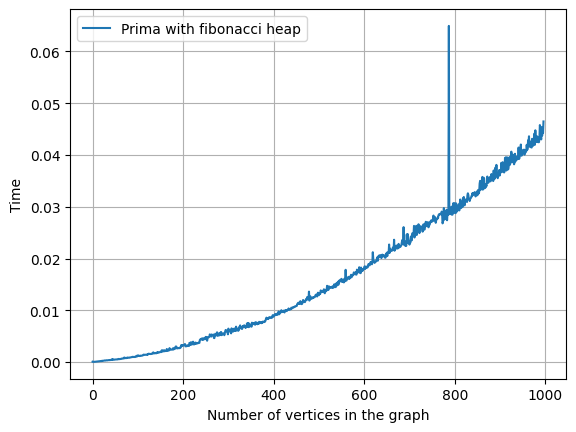

In [19]:
plt.plot(times_fibheap, label = 'Prima with fibonacci heap')
plt.legend()
plt.xlabel('Number of vertices in the graph')
plt.ylabel('Time')
plt.grid()
plt.show()

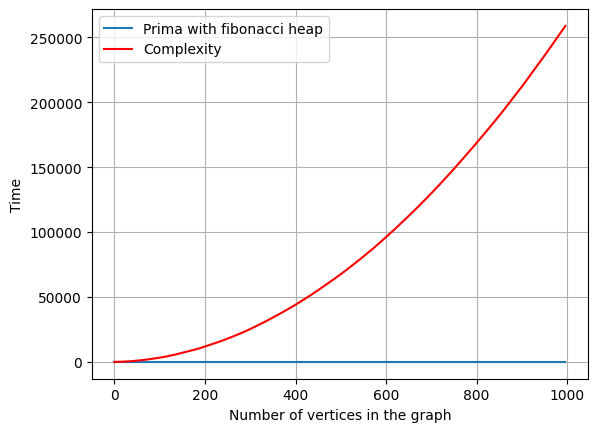

In [20]:
plt.plot(times_fibheap, label = 'Prima with fibonacci heap')
plt.plot(complexity, color = 'red', label = 'Complexity')
plt.legend()
plt.xlabel('Number of vertices in the graph')
plt.ylabel('Time')
plt.grid()
plt.show()

## Сomparison of results

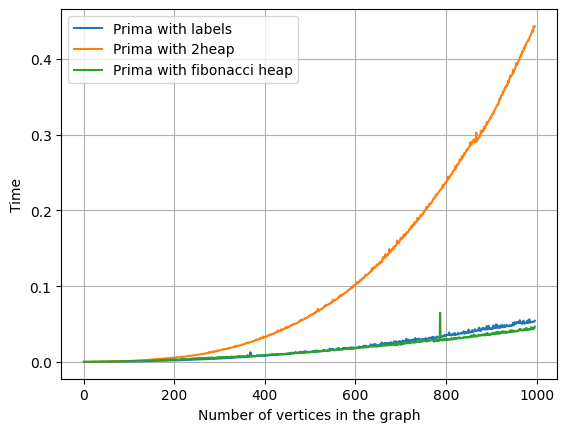

In [21]:
plt.plot(times_labels, label = 'Prima with labels')
plt.plot(times_2heap, label = 'Prima with 2heap')
plt.plot(times_fibheap, label = 'Prima with fibonacci heap')
plt.legend()
plt.xlabel('Number of vertices in the graph')
plt.ylabel('Time')
plt.grid()
plt.show()